In [166]:
## imports and globals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DUMMY_ACCT_BASE = 100000
STDDEV_CUTOFF = 1.5
MONTH_CUTOFF = 3

## list of the columns with gas usage by month
therm_months = ['thrm_jan', 'thrm_feb', 'thrm_mar', 'thrm_apr', 'thrm_may', 'thrm_jun',
                'thrm_jul', 'thrm_aug', 'thrm_sep', 'thrm_oct', 'thrm_nov', 'thrm_dec']

In [167]:
## borrowed this function from https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf

def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)
  

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.figure(figsize=(20, 6))
    plt.show()

In [168]:
## read in csv
svce_df = pd.read_csv('data/Powerhouse_SunCode_SVCE_Data.csv', index_col=False)

## Create dummy account numbers for dataset as index
svce_df['ACCT_NUMBER'] = np.arange(len(svce_df)) + DUMMY_ACCT_BASE
svce_df.set_index('ACCT_NUMBER', inplace=True)

## Create column of total therm usage
svce_df['total_therms'] = svce_df[therm_months].sum(axis=1)
display(svce_df.head(5))

,CITY,ENDUSE,CSCHJAN_2018,CSCHFEB_2018,CSCHMAR_2018,CSCHAPR_2018,CSCHMAY_2018,CSCHJUN_2018,CSCHJUL_2018,CSCHAUG_2018,...,thrm_may,thrm_jun,thrm_jul,thrm_aug,thrm_sep,thrm_oct,thrm_nov,thrm_dec,Advanced_Vehicle_Fuel,total_therms
ACCT_NUMBER,,,,,,,,,,,,,,,,,,,,,
100000,UNINCORPORATED,BASIC ELECTRICITY,E1,E1,E1,E1,E1,E1,E1,E1,...,30.0,18.0,14.0,16.0,19.0,17.0,22.0,68.0,NaN,438.0
100001,SARATOGA,BASIC ELECTRICITY,ETOUA,ETOUA,ETOUA,ETOUA,ETOUA,ETOUA,ETOUA,ETOUA,...,70.0,45.0,49.0,70.0,44.0,47.0,179.0,223.0,NaN,1548.0
100002,CAMPBELL,BASIC ELECTRICITY,E1,E1,E1,E1,E1,E1,E1,E1,...,24.0,20.0,14.0,26.0,NaN,15.0,16.0,27.0,NaN,282.0
100003,LOS ALTOS,BASIC ELECTRICITY,E1,E1,E1,E1,E1,E1,E1,E1,...,24.0,18.0,17.0,18.0,16.0,14.0,25.0,34.0,NaN,385.0
100004,UNINCORPORATED,ALL ELEC./SPACE HEAT 1985 ONLY,E1,E1,E1,E1,E1,E1,E1,E1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [175]:
## function to apply to rows to determine the # of months above STDDEV_CUTOFFs above std_dev
##   and most extreme month above in terms of std_dev above

## brute force method -- numpy array implementation would be much faster
def calculate_months_above(bed, df):
    ''' This function returns a series to be added as a new column representing the 
        number of months that this user is STDDEV_CUTOFFs (currently 1.5) times the standard
        deviation above the median for bed number of bedroom households'''
    for month in therm_months:
        key = month+"_"+str(bed)
        df.loc[:,month] = df[month].apply(lambda x: (x - std_cutoffs[key] > 0))
        
    months_above = df.sum(axis=1)
    return months_above
  

In [176]:
## add column for number of months above the median
#svce_df['months_above'] = 0

## create dfs for every bedroom category
## bed_dict[#] accesses the df with # of bedrooms
bed_dict = {beds: svce_df[svce_df['BEDROOMS'] == beds] 
            for beds in range(svce_df['BEDROOMS'].max()+1)}

## dicts to hold values by # of bedrooms and month
medians = {}
std_devs = {}
std_cutoffs = {}  

## determine mean, and std_dev for each month 
## calculate number of months acct is above STDDEV_CUTOFFs above std_dev
for bed, df in bed_dict.items():
    for month in therm_months:
        key = month+"_"+str(bed)
        medians[key] = df[month].median()
        std_devs[key] = df[month].std()
        std_cutoffs[key] = (medians[key] + std_devs[key] * STDDEV_CUTOFF)
        
    df.loc[:,'months_above'] = calculate_months_above(bed, df[therm_months])
    
    display(df[['CITY','BEDROOMS', 'TOTAL_AREA', 'months_above']].head(5))

,CITY,BEDROOMS,TOTAL_AREA,months_above
ACCT_NUMBER,,,,
101008,LOS GATOS,0,750,0
102692,UNINCORPORATED,0,3750,0
104596,LOS GATOS,0,750,0
104702,CUPERTINO,0,750,0
105314,MORGAN HILL,0,250,0


,CITY,BEDROOMS,TOTAL_AREA,months_above
ACCT_NUMBER,,,,
100019,MOUNTAIN VIEW,1,750,0
100028,MOUNTAIN VIEW,1,750,0
100055,MILPITAS,1,500,0
100114,UNINCORPORATED,1,1000,0
100168,MOUNTAIN VIEW,1,750,0


,CITY,BEDROOMS,TOTAL_AREA,months_above
ACCT_NUMBER,,,,
100000,UNINCORPORATED,2,1000,0
100002,CAMPBELL,2,1250,0
100008,LOS ALTOS,2,750,0
100010,LOS ALTOS,2,1000,0
100017,LOS ALTOS,2,1000,0


,CITY,BEDROOMS,TOTAL_AREA,months_above
ACCT_NUMBER,,,,
100004,UNINCORPORATED,3,750,0
100005,SUNNYVALE,3,1000,0
100007,SARATOGA,3,2500,8
100012,CAMPBELL,3,2000,0
100013,UNINCORPORATED,3,2500,8


,CITY,BEDROOMS,TOTAL_AREA,months_above
ACCT_NUMBER,,,,
100001,SARATOGA,4,5000,9
100003,LOS ALTOS,4,1750,0
100006,CAMPBELL,4,2250,0
100009,SUNNYVALE,4,1750,0
100011,GILROY,4,2000,0


,CITY,BEDROOMS,TOTAL_AREA,months_above
ACCT_NUMBER,,,,
100031,SUNNYVALE,5,3000,0
100050,SUNNYVALE,5,2000,0
100057,CUPERTINO,5,3500,0
100068,MILPITAS,5,3000,0
100083,MILPITAS,5,3500,2


In [177]:
for bed, df in bed_dict.items():
    print ("{} out of {} total households with above average gas usage with {} bedrooms".format(len(df[df['months_above'] >= MONTH_CUTOFF]), len(df), bed))

4 out of 43 total households with above average gas usage with 0 bedrooms
80 out of 1048 total households with above average gas usage with 1 bedrooms
361 out of 8090 total households with above average gas usage with 2 bedrooms
2626 out of 23177 total households with above average gas usage with 3 bedrooms
1857 out of 17969 total households with above average gas usage with 4 bedrooms
633 out of 6344 total households with above average gas usage with 5 bedrooms


Targetted Households by  number of bedrooms
=====================================

4 out of 43 total households with above average gas usage with 0 bedrooms<br>
80 out of 1048 total households with above average gas usage with 1 bedrooms<br>
361 out of 8090 total households with above average gas usage with 2 bedrooms<br>
2626 out of 23177 total households with above average gas usage with 3 bedrooms<br>
1857 out of 17969 total households with above average gas usage with 4 bedrooms<br>
633 out of 6344 total households with above average gas usage with 5 bedrooms

In [178]:
## create a csv of targeted households

months_above_cat = pd.concat(bed_dict.values())
targeted = months_above_cat[months_above_cat['months_above'] >= MONTH_CUTOFF]
    
targeted.to_csv('data/targeted.csv')

In [179]:
## create a json of targeted households total therm usage
targeted['total_therms'].to_json('data/targeted_total.json')

In [180]:
## create a list of account numbers to access via json as examples
loclist = [3, 3+80, 3+80+361, 3+80+361+2626, 3+80+361+2626+1857, 3+80+361+2626+1857+633] # last member of each bdrm group
acctlist = targeted.index.values[loclist]
print(acctlist)

[143385 155951 156175 156631 156648 156578]


LIST OF RANDOM ACCTS TO USE AS EXAMPLE DATA FROM JSON
=====================================================

143385 155951 156175 156631 156648 156578<br><br>


count     144.000000
mean      469.138889
std       267.541504
min       203.000000
25%       258.750000
50%       371.500000
75%       679.000000
max      1250.000000
Name: thrm_jul, dtype: float64
mode:  0    443.0
1    679.0
2    721.0
dtype: float64


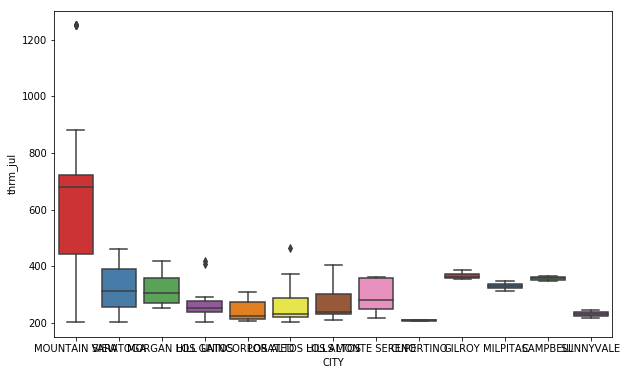

<Figure size 1440x432 with 0 Axes>

In [154]:
## a tiny bit of eda on high users by location

# users who use more than 200 therms in july
crazy_usage = svce_df[svce_df['thrm_jul'] > 200]
# display(crazy_usage.info())
# display(crazy_usage.head(10))

quantitative_summarized(crazy_usage, x='CITY', y='thrm_jul', hue=None, palette='Set1', ax=None, verbose=False, swarm=False)

crazy_usage.to_csv('data/high_gas_usage.csv')